In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
plt.style.use('seaborn-dark')

import sys
sys.path.insert(0, '../..')

import quan_utils

In [2]:
prob_df = pd.read_csv('../../data/data.csv', index_col=0)
capacity_df = prob_df['Real'].value_counts()

NUM_SAMPLES = 5
BUDGETS = [10, 10, 10, 10, 10]
TYPES = ['ES', 'PSH', 'TH', 'RRH', 'PREV']
COST_TYPES = ['linear', 'linear', 'linear', 'linear', 'linear']


def capacity_cost(capacity_increases):
    running_total = 0
    
    for type_index, increase in enumerate(capacity_increases):
        if COST_TYPES[type_index] == 'linear':
            running_total += increase
        elif COST_TYPES[type_index] == 'log':
            running_total += np.log(increase + 1)
        elif COST_TYPES[type_index] == 'quadratic':
            running_total += increase ** 2
    
    return running_total


# All objective functions
def f(x):
    fairness_constraint = x[0]
    
    helper = quan_utils.AssignmentHelper()
    
    new_capacity_df = capacity_df.copy()
    for type_index, type_ in enumerate(TYPES):
        new_capacity_df.loc[type_index + 1] += x[type_index + 1]
    
    helper.update_constraints(
        fairness_constraint=fairness_constraint,
        capacity_df=new_capacity_df
    )
    
    sol_df = helper.ip_solve()
    real_n_reentries, bart_n_reentries, sol_n_reentries = helper.compare_reentry(sol_df, verbose=False)
    prob_compare_df = helper.compare_prob(sol_df)
    
    # return np.hstack((
    #     [[- (real_n_reentries - sol_n_reentries) / real_n_reentries * 100]],
    #     [[prob_compare_df[prob_compare_df['Diff'] > 0]['Diff'].mean()]],
    #     capacity_cost(x[1 :])
    # ))
    
    return (
        (real_n_reentries - sol_n_reentries) / real_n_reentries * 100,
        prob_compare_df['Diff'].max(),
        prob_compare_df[prob_compare_df['Diff'] > 0]['Diff'].mean(),
        prob_compare_df[prob_compare_df['Diff'] > 0]['Diff'].quantile(0.75),
        prob_compare_df['Diff'].max() - prob_compare_df['Diff'].min(),
        capacity_cost(x[1:])
    )

In [3]:
increase_budget = 5

xs = [[[0.05, i * 10, 0, 0, 0, j * 10] 
       for j in range(increase_budget)]
      for i in range(increase_budget)]
xs

[[[0.05, 0, 0, 0, 0, 0],
  [0.05, 0, 0, 0, 0, 10],
  [0.05, 0, 0, 0, 0, 20],
  [0.05, 0, 0, 0, 0, 30],
  [0.05, 0, 0, 0, 0, 40]],
 [[0.05, 10, 0, 0, 0, 0],
  [0.05, 10, 0, 0, 0, 10],
  [0.05, 10, 0, 0, 0, 20],
  [0.05, 10, 0, 0, 0, 30],
  [0.05, 10, 0, 0, 0, 40]],
 [[0.05, 20, 0, 0, 0, 0],
  [0.05, 20, 0, 0, 0, 10],
  [0.05, 20, 0, 0, 0, 20],
  [0.05, 20, 0, 0, 0, 30],
  [0.05, 20, 0, 0, 0, 40]],
 [[0.05, 30, 0, 0, 0, 0],
  [0.05, 30, 0, 0, 0, 10],
  [0.05, 30, 0, 0, 0, 20],
  [0.05, 30, 0, 0, 0, 30],
  [0.05, 30, 0, 0, 0, 40]],
 [[0.05, 40, 0, 0, 0, 0],
  [0.05, 40, 0, 0, 0, 10],
  [0.05, 40, 0, 0, 0, 20],
  [0.05, 40, 0, 0, 0, 30],
  [0.05, 40, 0, 0, 0, 40]]]

In [4]:
percentage_reductions = []
max_prob_diff = []
avg_pos_prob_increase = []
thirdq_pos_prob_increase = []
range_prob_diff = []
capacity_costs = []

for i in range(increase_budget):
    print(i)
    
    percentage_reductions.append([])
    max_prob_diff.append([])
    avg_pos_prob_increase.append([])
    thirdq_pos_prob_increase.append([])
    range_prob_diff.append([])
    capacity_costs.append([])
    
    for j in range(increase_budget):
        result = f(xs[i][j])
        
        percentage_reductions[-1].append(result[0])
        max_prob_diff[-1].append(result[1])
        avg_pos_prob_increase[-1].append(result[2])
        thirdq_pos_prob_increase[-1].append(result[3])
        range_prob_diff[-1].append(result[4])
        capacity_costs[-1].append(result[5])

0 0
0 1
0 2
0 3
0 4
1 0
1 1
1 2
1 3
1 4
2 0
2 1
2 2
2 3
2 4
3 0
3 1
3 2
3 3
3 4
4 0
4 1
4 2
4 3
4 4


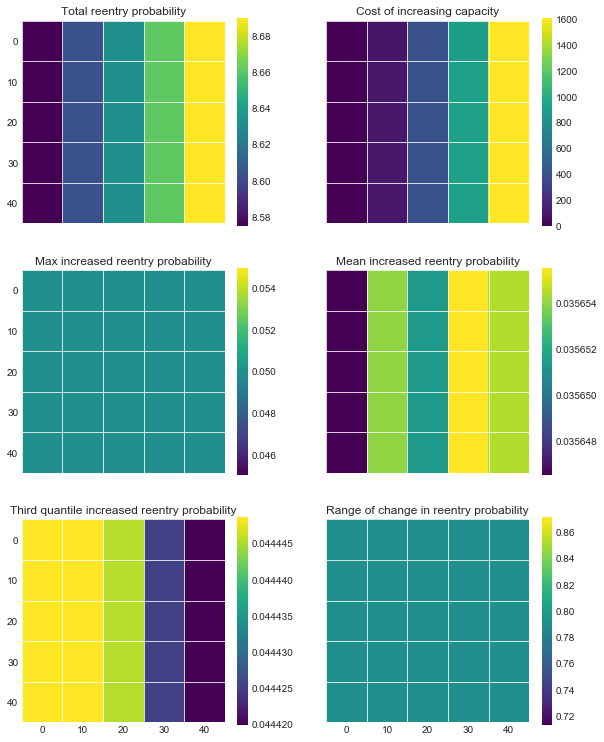

In [14]:
xlabels = [i * 10 for i in range(increase_budget)]
ylabels = [j * 10 for j in range(increase_budget)]

f, ax = plt.subplots(3, 2, figsize=(10, 13), sharex=True, sharey=True)

# Utility and cost in the first row
m = ax[0][0].imshow(percentage_reductions, cmap='viridis')
f.colorbar(m, ax=ax[0][0])
ax[0][0].set_title('Total reentry probability')

m = ax[0][1].imshow(capacity_costs, cmap='viridis')
f.colorbar(m, ax=ax[0][1])
ax[0][1].set_title('Cost of increasing capacity')

# Second and third rows contain fairness metrics
m = ax[1][0].imshow(max_prob_diff, cmap='viridis')
f.colorbar(m, ax=ax[1][0])
ax[1][0].set_title('Max increased reentry probability')

m = ax[1][1].imshow(avg_pos_prob_increase, cmap='viridis')
f.colorbar(m, ax=ax[1][1])
ax[1][1].set_title('Mean increased reentry probability')

m = ax[2][0].imshow(thirdq_pos_prob_increase, cmap='viridis')
f.colorbar(m, ax=ax[2][0])
ax[2][0].set_title('Third quantile increased reentry probability')

m = ax[2][1].imshow(range_prob_diff, cmap='viridis')
f.colorbar(m, ax=ax[2][1])
ax[2][1].set_title('Range of change in reentry probability')

ax[0][0].set_yticks([i for i in range(increase_budget)])
ax[0][0].set_yticklabels(ylabels)
ax[1][0].set_yticks([i for i in range(increase_budget)])
ax[1][0].set_yticklabels(ylabels)
ax[2][0].set_yticks([i for i in range(increase_budget)])
ax[2][0].set_yticklabels(ylabels)

ax[2][0].set_xticks([i for i in range(increase_budget)])
ax[2][0].set_xticklabels(xlabels)
ax[2][1].set_xticks([i for i in range(increase_budget)])
ax[2][1].set_xticklabels(xlabels)

for row in range(3):
    for col in range(2):
        ax[row][col].set_xticks(
            [i - 0.5 for i in range(increase_budget + 1)], 
            minor=True
        )
        ax[row][col].set_yticks(
            [i - 0.5 for i in range(increase_budget + 1)], 
            minor=True
        )
        ax[row][col].grid(b=None)
        ax[row][col].grid(which='minor')

plt.show()

# Scratch paper

In [7]:
percentage_reductions

[[8.574815287359408,
  8.603610015605359,
  8.632362810485326,
  8.661072933072301,
  8.689746286403963],
 [8.574815287359408,
  8.603610015605359,
  8.632362810485326,
  8.661072933072301,
  8.689746286403963],
 [8.574815287359408,
  8.603610015605359,
  8.632362810485326,
  8.661072933072301,
  8.689746286403963],
 [8.574815287359408,
  8.603610015605359,
  8.632362810485326,
  8.661072933072301,
  8.689746286403963],
 [8.574815287359408,
  8.603610015605359,
  8.632362810485326,
  8.661072933072301,
  8.689746286403963]]

In [8]:
capacity_costs

[[0.0, 100.0, 400.0, 900.0, 1600.0],
 [2.3978952727983707,
  102.39789527279837,
  402.3978952727984,
  902.3978952727983,
  1602.3978952727985],
 [3.044522437723423,
  103.04452243772343,
  403.0445224377234,
  903.0445224377235,
  1603.0445224377233],
 [3.4339872044851463,
  103.43398720448515,
  403.43398720448516,
  903.4339872044851,
  1603.4339872044852],
 [3.713572066704308,
  103.7135720667043,
  403.71357206670433,
  903.7135720667043,
  1603.7135720667043]]

In [9]:
max_prob_diff

[[0.049991355000000015,
  0.049991355000000015,
  0.049991355000000015,
  0.049991355000000015,
  0.049991355000000015],
 [0.049991355000000015,
  0.049991355000000015,
  0.049991355000000015,
  0.049991355000000015,
  0.049991355000000015],
 [0.049991355000000015,
  0.049991355000000015,
  0.049991355000000015,
  0.049991355000000015,
  0.049991355000000015],
 [0.049991355000000015,
  0.049991355000000015,
  0.049991355000000015,
  0.049991355000000015,
  0.049991355000000015],
 [0.049991355000000015,
  0.049991355000000015,
  0.049991355000000015,
  0.049991355000000015,
  0.049991355000000015]]

In [10]:
avg_pos_prob_increase

[[0.03564648812158137,
  0.03565402612513543,
  0.03565134688539691,
  0.03565553537527115,
  0.035654497960108555],
 [0.03564648812158137,
  0.03565402612513543,
  0.03565134688539691,
  0.03565553537527115,
  0.035654497960108555],
 [0.03564648812158137,
  0.03565402612513543,
  0.03565134688539691,
  0.03565553537527115,
  0.035654497960108555],
 [0.03564648812158137,
  0.03565402612513543,
  0.03565134688539691,
  0.03565553537527115,
  0.035654497960108555],
 [0.03564648812158137,
  0.03565402612513543,
  0.03565134688539691,
  0.03565553537527115,
  0.035654497960108555]]

In [11]:
thirdq_pos_prob_increase

[[0.04444853,
  0.04444862025,
  0.044445466,
  0.04442554950000002,
  0.04441993200000002],
 [0.04444853,
  0.04444862025,
  0.044445466,
  0.04442554950000002,
  0.04441993200000002],
 [0.04444853,
  0.04444862025,
  0.044445466,
  0.04442554950000002,
  0.04441993200000002],
 [0.04444853,
  0.04444862025,
  0.044445466,
  0.04442554950000002,
  0.04441993200000002],
 [0.04444853,
  0.04444862025,
  0.044445466,
  0.04442554950000002,
  0.04441993200000002]]

In [12]:
range_prob_diff

[[0.7922888290000001,
  0.7922888290000001,
  0.7922888290000001,
  0.7922888290000001,
  0.7922888290000001],
 [0.7922888290000001,
  0.7922888290000001,
  0.7922888290000001,
  0.7922888290000001,
  0.7922888290000001],
 [0.7922888290000001,
  0.7922888290000001,
  0.7922888290000001,
  0.7922888290000001,
  0.7922888290000001],
 [0.7922888290000001,
  0.7922888290000001,
  0.7922888290000001,
  0.7922888290000001,
  0.7922888290000001],
 [0.7922888290000001,
  0.7922888290000001,
  0.7922888290000001,
  0.7922888290000001,
  0.7922888290000001]]